## LSTMs with KNNs and SVMs

In [18]:
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data preparation

In [19]:
feature_cols = pickle.load(open("../status/common/feature_cols.p", "rb"))

def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=len(feature_cols), activation='relu')) # input_dim should be the number of features
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
# Load data
df = pickle.load(open('../metrics/common/pima.p', 'rb'))
clf = pickle.load(open("../status/models/knn.p", "rb"))
scalers = pickle.load(open('../metrics/models/multivariate/lstm/_scalers.p', 'rb'))
predictions = pickle.load(open('../metrics/models/multivariate/lstm/_predictions_result.p', 'rb'))
actual_status = pickle.load(open('../metrics/models/multivariate/lstm/_statuses_test.p', 'rb'))
split_size = pickle.load(open('../metrics/common/split_size.p', 'rb'))
X = pickle.load(open("../status/common/feature_status.p", "rb"))
y = pickle.load(open("../status/common/target_status.p", "rb"))
n_past = pickle.load(open('../metrics/common/n_past.p', 'rb'))

# Convert the dictionary to a pandas DataFrame
df_predictions = pd.DataFrame(predictions)
np_predictions = pd.DataFrame(df_predictions.values, columns=feature_cols)

# Prepare the training and test sets
train_size = int(len(df) * split_size) + n_past
test_size = len(df) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

### Train the KNNs model

In [21]:
# based from ../status/status.knn.ipynb
best_n_neighbors = 7

# Create and train the model
clf_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
clf_knn.fit(X_train, y_train)

# Use the classification model to predict the statuses based on the LSTM predictions
y_pred_knn = clf_knn.predict(np_predictions)

print("Accuracy:", accuracy_score(actual_status, y_pred_knn))
print("Recall:", recall_score(actual_status, y_pred_knn))
print("Precision:", precision_score(actual_status, y_pred_knn))

clf_knn_matrix = confusion_matrix(actual_status, y_pred_knn)
print("Confusion Matrix:")
print(clf_knn_matrix)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.910377358490566
Recall: 0.4838709677419355
Precision: 0.40540540540540543
Confusion Matrix:
[[371  22]
 [ 16  15]]


Text(0.5, 427.9555555555555, 'Predicted Label')

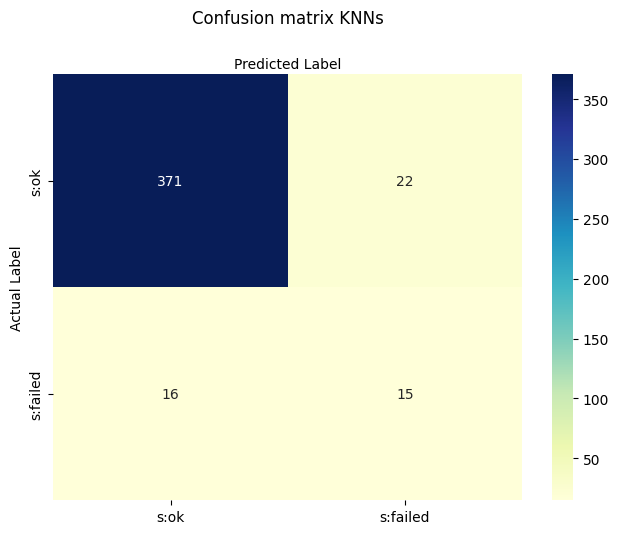

In [22]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_knn_matrix_df = pd.DataFrame(clf_knn_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_knn_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix KNNs', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Train the SVMs model

In [23]:
# Create and train the model
clf_svm = svm.SVC(kernel='linear', C=1, random_state=42)
clf_svm.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred_svm = clf_svm.predict(np_predictions)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))

clf_svm_matrix = confusion_matrix(y_test, y_pred_svm)
clf_svm_matrix

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.910377358490566
Precision: 0.42857142857142855
Recall: 0.6774193548387096


array([[365,  28],
       [ 10,  21]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

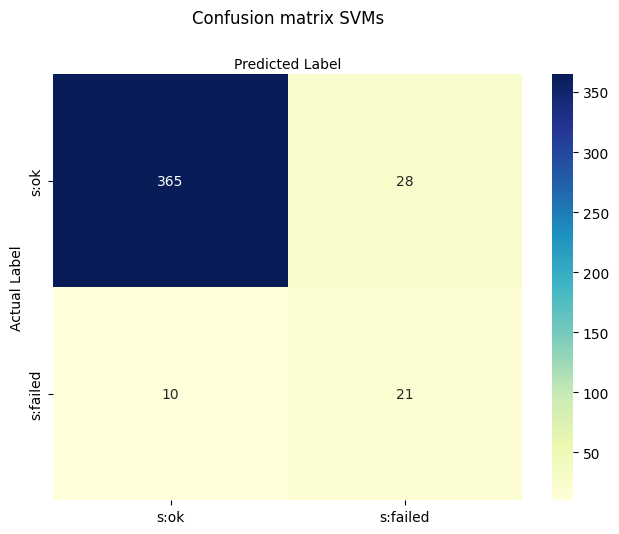

In [24]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_svm_matrix_df = pd.DataFrame(clf_svm_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_svm_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix SVMs', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Train the decision tree model

In [25]:
# Create and train the model
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred_dt = clf_dt.predict(np_predictions)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))

clf_dt_matrix = confusion_matrix(y_test, y_pred_dt)
clf_dt_matrix

Accuracy: 0.9150943396226415
Precision: 0.42424242424242425
Recall: 0.45161290322580644


array([[374,  19],
       [ 17,  14]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

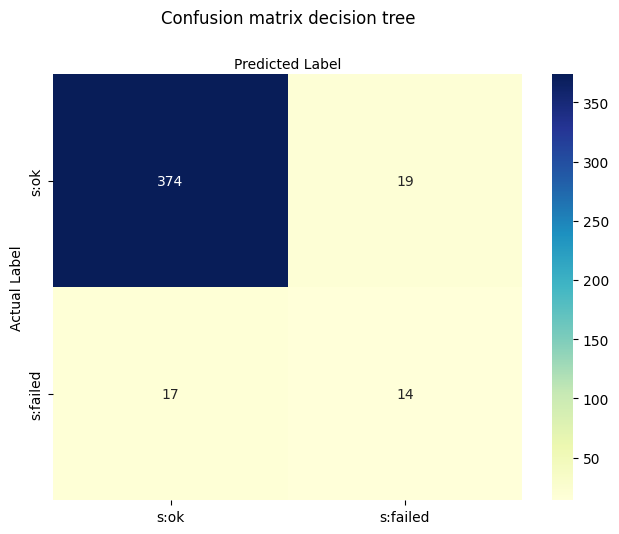

In [26]:
# Assuming clf_dt_matrix is the confusion matrix you've computed
clf_dt_matrix_df = pd.DataFrame(clf_dt_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_dt_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix decision tree', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Train the logistic regression model

In [27]:
# Create and train the model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred_lr = clf.predict(np_predictions)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))

clf_lr_matrix = confusion_matrix(y_test, y_pred_lr)
clf_lr_matrix

Accuracy: 0.9174528301886793
Precision: 0.4583333333333333
Recall: 0.7096774193548387


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[367,  26],
       [  9,  22]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

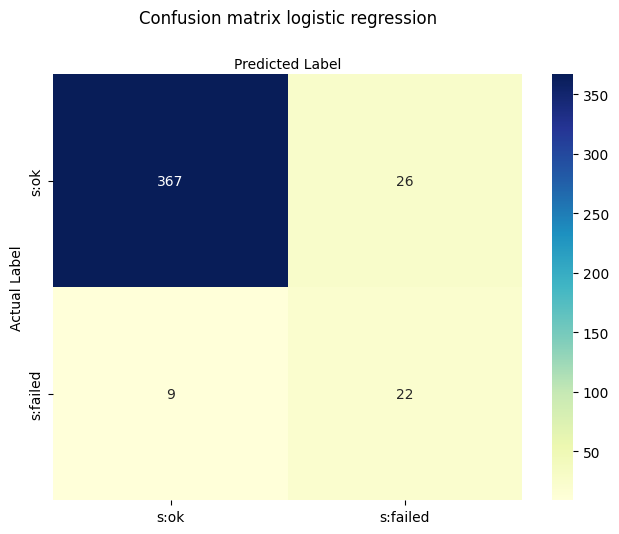

In [28]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_lr_matrix_df = pd.DataFrame(clf_lr_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_lr_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix logistic regression', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Train the neural network model

In [29]:
# Create the KerasClassifier
clf_nn = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Fit the model to the training data
clf_nn.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred_nn = clf_nn.predict(np_predictions)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))

clf_nn_matrix = confusion_matrix(y_test, y_pred_nn)
clf_nn_matrix

C:\Users\dell\AppData\Local\Temp\ipykernel_23456\2195287474.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_nn = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


14/14 [==============================] - 0s 1ms/step
Accuracy: 0.8773584905660378
Precision: 0.34782608695652173
Recall: 0.7741935483870968


array([[348,  45],
       [  7,  24]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

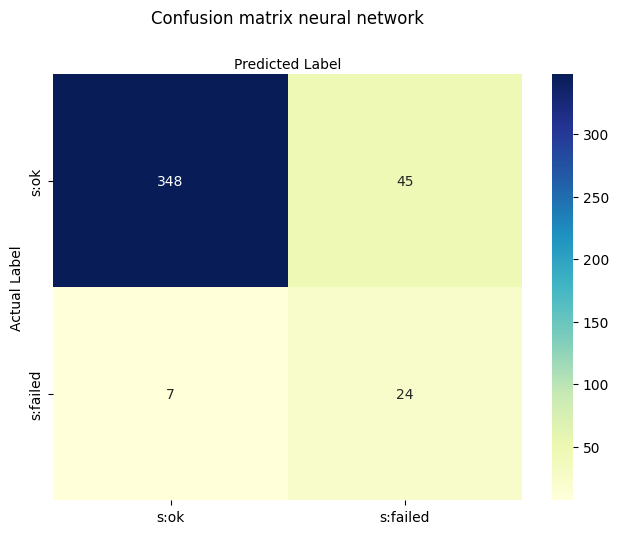

In [30]:
# Assuming clf_nn_matrix is the confusion matrix you've computed
clf_nn_matrix_df = pd.DataFrame(clf_nn_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_nn_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix neural network', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Ensemble the models

In [31]:
result_false = []

for i in range(len(actual_status)):
    dt_result = y_pred_dt[i]
    svm_result = y_pred_svm[i]
    knn_result = y_pred_knn[i]
    lr_result = y_pred_lr[i]
    nn_result = y_pred_nn[i]
        
    if dt_result == 1 or svm_result == 1 or knn_result == 1 or lr_result == 1 or nn_result == 1:
        result_false.append(1)
    else:
        result_false.append(0)

print("Accuracy:", accuracy_score(actual_status, result_false))
print("Precision:", precision_score(actual_status, result_false))
print("Recall:", recall_score(actual_status, result_false))

result_false_matrix = confusion_matrix(actual_status, result_false)
result_false_matrix

Accuracy: 0.8867924528301887
Precision: 0.3835616438356164
Recall: 0.9032258064516129


array([[348,  45],
       [  3,  28]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

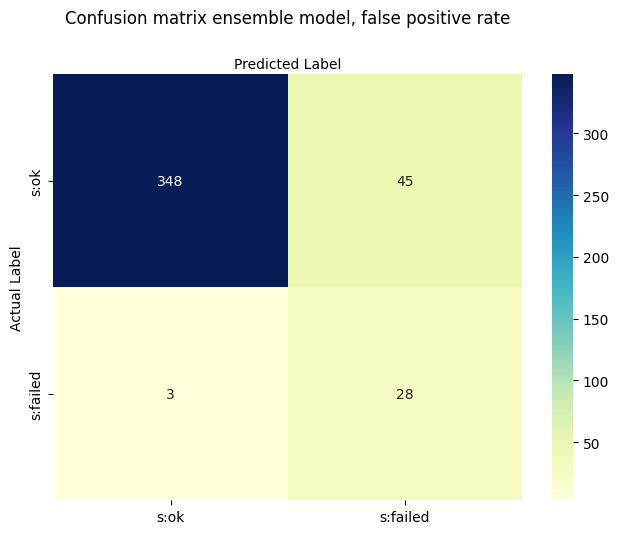

In [32]:
# Assuming result_false_matrix is the confusion matrix you've computed
result_false_matrix_df = pd.DataFrame(result_false_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(result_false_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix ensemble model, false positive rate', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [33]:
result = []

for i in range(len(actual_status)):
    ok_count = 0
    failed_count = 0
    dt_result = y_pred_dt[i]
    svm_result = y_pred_svm[i]
    knn_result = y_pred_knn[i]
    lr_result = y_pred_lr[i]
    nn_result = y_pred_nn[i]
        
    if dt_result == 1:
        failed_count += 1
    else:
        ok_count += 1

    if svm_result == 1:
        failed_count += 1
    else:
        ok_count += 1
    
    if knn_result == 1:
        failed_count += 1
    else:
        ok_count += 1

    if lr_result == 1:
        failed_count += 1
    else:
        ok_count += 1

    if nn_result == 1:
        failed_count += 1
    else:
        ok_count += 1
    
    if failed_count >= ok_count:
        result.append(1)
    else:
        result.append(0)

print("Accuracy:", accuracy_score(actual_status, result))
print("Precision:", precision_score(actual_status, result))
print("Recall:", recall_score(actual_status, result))

result_matrix = confusion_matrix(actual_status, result)
result_matrix

Accuracy: 0.9150943396226415
Precision: 0.44680851063829785
Recall: 0.6774193548387096


array([[367,  26],
       [ 10,  21]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

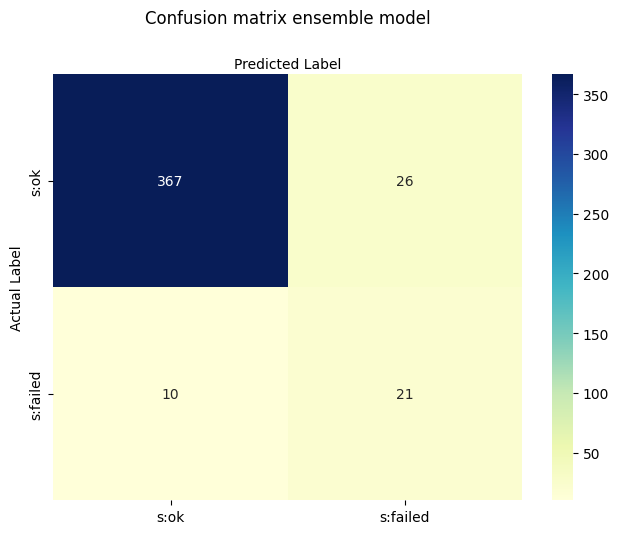

In [34]:
# Assuming result_matrix is the confusion matrix you've computed
result_matrix_df = pd.DataFrame(result_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(result_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix ensemble model', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')